In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import json
from time_series_split import *

ModuleNotFoundError: No module named 'fetching_meteorological'

In [ ]:
def calculate_aqi(pm25):
    ranges = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.0, 301, 500),
    ]
    for c_low, c_high, aqi_low, aqi_high in ranges:
        if c_low <= pm25 <= c_high:
            return round((aqi_high - aqi_low) / (c_high - c_low) * (pm25 - c_low) + aqi_low)
    return 500  # default nếu vượt ngưỡng

def aqi_class(aqi):
    if aqi <= 50: return 0
    elif aqi <= 100: return 1
    elif aqi <= 150: return 2
    elif aqi <= 200: return 3
    elif aqi <= 300: return 4
    else: return 5

In [ ]:
combined_data = pd.read_csv('/home/thu/INT3041E_AI_PM2.5-Concentration-Estimation/data/add_AQI.csv')
combined_data['AQI'] = combined_data['pm25'].apply(calculate_aqi)
combined_data['AQI_Class'] = combined_data['AQI'].apply(aqi_class)

In [ ]:
combined_data.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,NDVI,CO,HCHO,NO2,SO2,CLOUD,O3,AAI,AQI,AQI_Class
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,...,0.000551,0.045586,0.000060,0.000072,0.000035,0.711612,0.101653,-0.836203,183,3
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,...,-0.003006,0.041913,0.000107,0.000086,0.000056,0.761720,0.103635,-0.718537,177,3
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,...,0.004388,0.042329,0.000108,0.000071,0.000026,0.867689,0.102144,-0.942304,183,3
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,...,-0.001733,0.041913,0.000097,0.000085,0.000079,0.779294,0.102875,-0.692613,183,3
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,...,0.016035,0.042298,0.000115,0.000082,-0.000345,0.705396,0.103488,-1.119681,162,3


In [ ]:
# folds = split_original_data()
folds = split_consolidated_data()
print(f"Number of folds: {len(folds)}")

Number of folds: 3


In [ ]:
fold = folds[0]
train_data = fold['train']
val_data = fold['validation']
test_data = fold['test']

In [ ]:
# Chuẩn bị features và target từ các DataFrame
# Features: Loại trừ pm25, AQI, AQI_Class (tương tự cột 2 đến -2 trong combined_data)
feature_columns = train_data.columns[3:-2]  # Từ cột 3 (lat) đến cột -2 (AAI)

X_train = train_data[feature_columns]
y_train = train_data['AQI_Class']

X_val = val_data[feature_columns]
y_val = val_data['AQI_Class']

X_test = test_data[feature_columns]
y_test = test_data['AQI_Class']

In [ ]:
feature_columns

Index(['lat', 'lon', 'SQRT_SEA_DEM_LAT', 'WSPD', 'WDIR', 'TMP', 'TX', 'TN',
       'TP', 'RH', 'PRES2M', 'NDVI', 'CO', 'HCHO', 'NO2', 'SO2', 'CLOUD', 'O3',
       'AAI'],
      dtype='object')

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42) 
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10193, 19), y_train shape: (10193,)
X_val shape: (366, 19), y_val shape: (366,)
X_test shape: (327, 19), y_test shape: (327,)


## Tuning parameters

In [ ]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

**RandomForest**

In [ ]:
# rf_params = {
#     'n_estimators': [int(x) for x in np.linspace(100, 1200, 12)],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [int(x) for x in np.linspace(5, 30, 6)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# rf_model = RandomForestClassifier(random_state=43, class_weight='balanced')
# rf_search = RandomizedSearchCV(rf_model, rf_params, cv=strat_kfold, scoring='accuracy', n_iter=50, n_jobs=-1, random_state=43)
# rf_search.fit(X_train, y_train)
# rf_val_acc = rf_search.score(X_val, y_val)

**XGBoost**

In [ ]:
# xgb_params = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }
# xgb_model = XGBClassifier(random_state=43, objective='multi:softmax', num_class=6, use_label_encoder=False, eval_metric='mlogloss')
# xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=strat_kfold, scoring='accuracy', n_iter=30, n_jobs=-1, random_state=43)
# xgb_search.fit(X_train, y_train)
# xgb_val_acc = xgb_search.score(X_val, y_val)


**CatBoost**

In [ ]:
cat_params = {
    'iterations': [100, 300, 500],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7]
}
cat_model = CatBoostClassifier(verbose=0, random_state=43)
cat_search = RandomizedSearchCV(cat_model, cat_params, cv=strat_kfold, scoring='accuracy', n_iter=30, n_jobs=-1, random_state=43)
cat_search.fit(X_train, y_train)
cat_val_acc = cat_search.score(X_val, y_val)


In [ ]:
models = {
    # 'RandomForest': (rf_search, rf_val_acc),
    # 'XGBoost': (xgb_search, xgb_val_acc),
    'CatBoost': (cat_search, cat_val_acc)
}

best_model_name = max(models, key=lambda k: models[k][1])
best_search, best_val_acc = models[best_model_name]
best_clf = best_search.best_estimator_
pred = best_clf.predict(X_test)

In [ ]:
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {best_val_acc:.4f}")

Best Model: CatBoost
Validation Accuracy: 0.6885


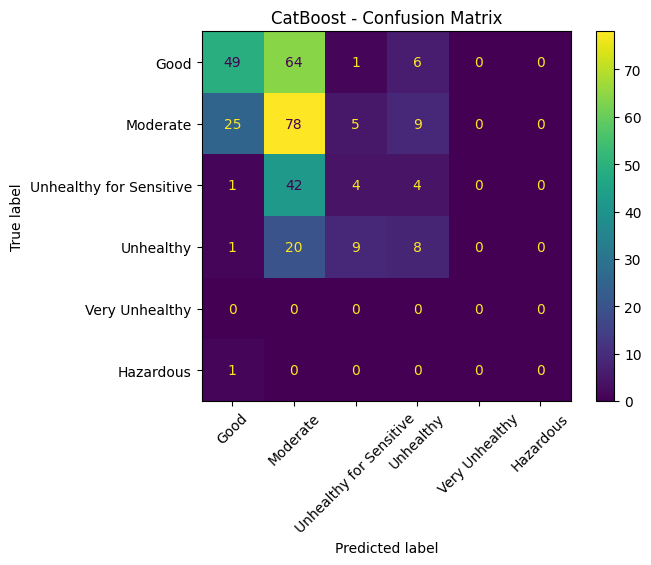

In [ ]:
all_labels = [0, 1, 2, 3, 4, 5]
target_names = ['Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

cm = confusion_matrix(y_test, pred, labels=all_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45)
plt.title(f'{best_model_name} - Confusion Matrix')
plt.show()

In [ ]:
print(f"Test Accuracy: {metrics.accuracy_score(y_test, pred):.4f}")
print("Classification Report (Test Set):")
print(metrics.classification_report(y_test, pred, labels=all_labels, target_names=target_names, zero_division=1))

Test Accuracy: 0.4251
Classification Report (Test Set):
                         precision    recall  f1-score   support

                   Good       0.64      0.41      0.50       120
               Moderate       0.38      0.67      0.49       117
Unhealthy for Sensitive       0.21      0.08      0.11        51
              Unhealthy       0.30      0.21      0.25        38
         Very Unhealthy       1.00      1.00      1.00         0
              Hazardous       1.00      0.00      0.00         1

               accuracy                           0.43       327
              macro avg       0.59      0.39      0.39       327
           weighted avg       0.44      0.43      0.40       327



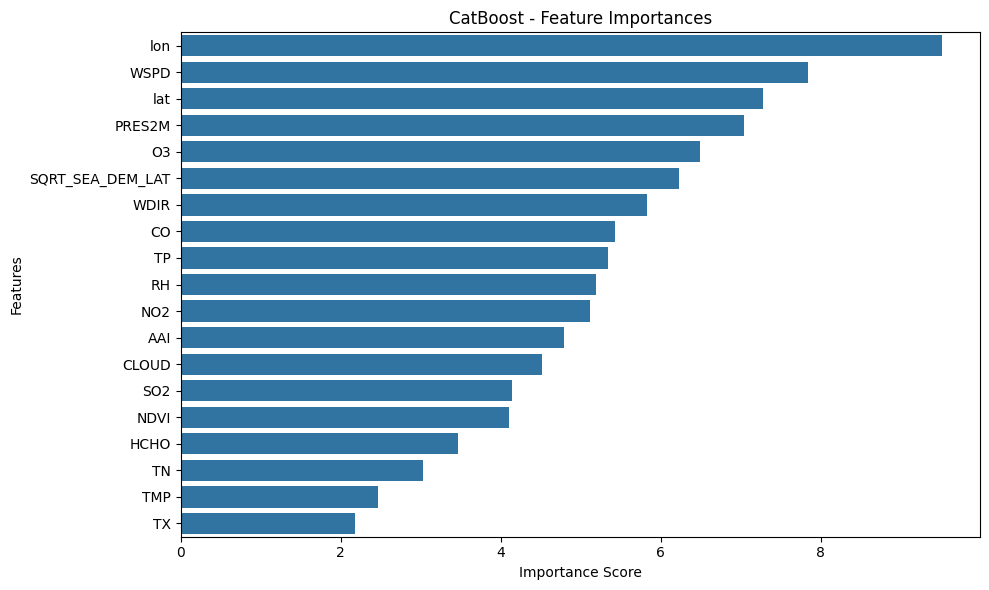

In [ ]:
# Feature Importance (nếu hỗ trợ)
try:
    importances = best_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=X_train.columns[indices])
    plt.title(f'{best_model_name} - Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
except:
    print("This model does not support feature_importances_.")

In [ ]:
# Lưu model & metadata

pickle.dump(best_clf, open(f'{best_model_name.lower()}-classifier-tuning.pkl', 'wb'))
metadata = {
    "model_name": best_model_name,
    "best_params": best_search.best_params_,
    "val_accuracy": best_val_acc,
    "test_accuracy": metrics.accuracy_score(y_test, pred),
    "features": list(feature_columns),
    "classes": sorted(list(set(y_train)))
}
with open(f"{best_model_name.lower()}_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

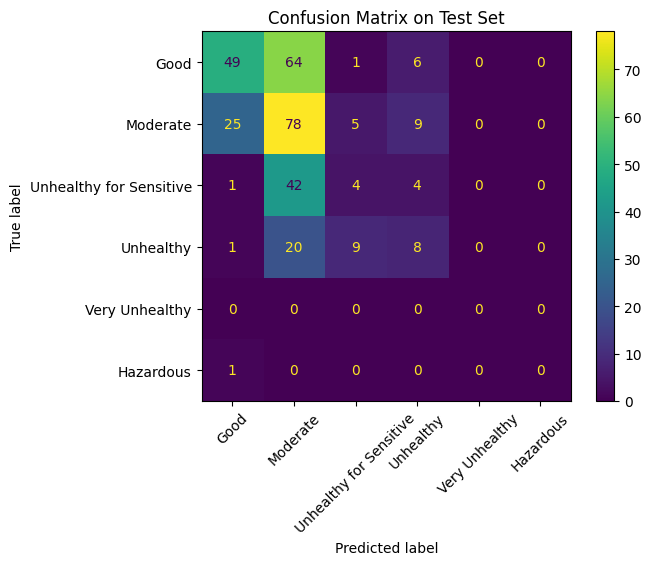

In [ ]:
# # Confusion Matrix
# cm = confusion_matrix(y_test, pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
#     'Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
# disp.plot(xticks_rotation=45)
# plt.title('Confusion Matrix on Test Set')
# plt.show()

all_labels = [0, 1, 2, 3, 4, 5]
cm = confusion_matrix(y_test, pred, labels=all_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    'Good', 'Moderate', 'Unhealthy for Sensitive', 'Unhealthy', 'Very Unhealthy', 'Hazardous'])
disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
# Feature importance
importances = best_clf.feature_importances_
indices = np.argsort(importances)[::-1]

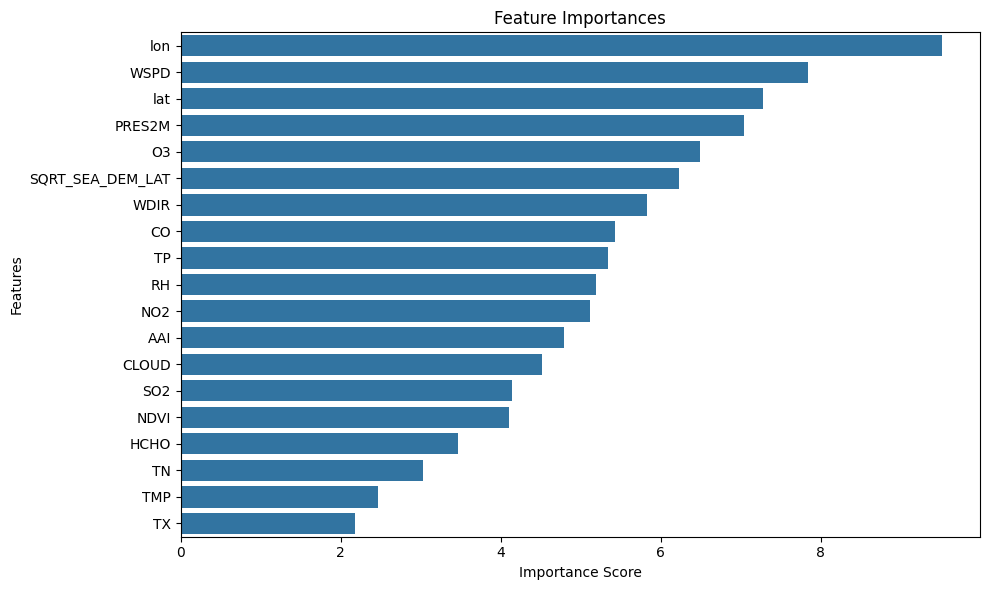

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()